## Implementation and Notes for Tutorial Article by Daniel Nouri
- [Using convolutional neural nets to detect facial keypoints tutorial by Daniel Nouri](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/)
- [Kaggle forum thread](https://www.kaggle.com/c/facial-keypoints-detection/details/deep-learning-tutorial)
- more about lasagne and nolearn
    - [Tutorial: Training convolutional neural networks with nolearn](http://nbviewer.ipython.org/github/dnouri/nolearn/blob/master/docs/notebooks/CNN_tutorial.ipynb)
    - [Kaggle: Otto Group Product Classification Challenge using nolearn/lasagne](https://github.com/ottogroup/kaggle/blob/master/Otto_Group_Competition.ipynb)
    - [mnist_conv_autoencode.ipynb](https://github.com/mikesj-public/convolutional_autoencoder/blob/master/mnist_conv_autoencode.ipynb)

*** Use ~~keras~~ Lasage and nolearn wrapper***

In [2]:
!cat /home/dola/.theanorc

[global]
floatX = float32
device = gpu0
#device = cpu

[nvcc]
fastmath = True

In [7]:
!head -n 1 ../data/kaggle-facial-keypoints/training.csv

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

In [96]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle

In [100]:
from lasagne import layers, updates
from nolearn.lasagne import NeuralNet ## nolearn wrapper for lasagne, need to install from git to support new lasagne

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense


In [9]:
## load data
def load_data(data_path):
    data = pd.read_csv(data_path)
    data["Image"] = data.Image.apply(lambda s: np.fromstring(s, sep = " "))
    return data

train_data = load_data("../data/kaggle-facial-keypoints/training.csv")
test_data = load_data("../data/kaggle-facial-keypoints/test.csv")
print train_data.shape, test_data.shape

(7049, 31) (1783, 2)


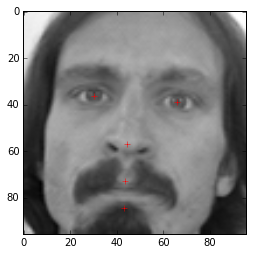

In [30]:
## show an example
plt.imshow(train_data["Image"][0].reshape(96, 96), cmap = plt.cm.gray)
plt.autoscale(False)
for p in [("left_eye_center_x","left_eye_center_y"), ("right_eye_center_x","right_eye_center_y")
         , ("nose_tip_x","nose_tip_y"), ("mouth_center_top_lip_x","mouth_center_top_lip_y"),
         ("mouth_center_bottom_lip_x","mouth_center_bottom_lip_y")]:
    x, y = train_data.ix[0, list(p)]
    plt.plot(x, y, "r+")

In [111]:
## prepare train and test data
## take images with all 30 targest, 
## normalize pixels to [0, 1], output (xs, ys) to [-1, 1]
X = np.vstack(train_data.dropna()["Image"]).astype(np.float32)
X = X / 255.
y = train_data.dropna()[[c for c in train_data.columns if c != "Image"]].get_values().astype(np.float32)
y = (y - 48.) / 48. # originally 96 x 96
## shuttle the data
X, y = shuffle(X, y, random_state = 0)
## split train and validation data

print X.shape, y.shape
print X.dtype, y.dtype
print X.min(), X.max(), y.min(), y.max()

(2140, 9216) (2140, 30)
float32 float32
0.0 1.0 -0.920287 0.99602


### Trying MLP

mlp takes flatten image vectors

In [114]:
## benchmark MLP with 1 hidden layer
## using nolearn wrapper - sklearn style interface - it follows an interface to sklearn.pipeline
net1 = NeuralNet(
    ## three layers
    layers = [("input", layers.InputLayer)
             , ("hidden", layers.DenseLayer)
             , ("output", layers.DenseLayer)]
    ## layer parameters - see lasagne.layers.XXX for parameter details
    , input_shape = (None, 9216) # batch size not fixed, input dim is 9216
    , hidden_num_units = 100
    , output_nonlinearity = None
    , output_num_units = 30
    
    ## optimization - update parameters,
    , update = updates.nesterov_momentum ## applicable to a wide range of problems
    , update_learning_rate = 0.01 # 0.01 and 0.9, kinda like defacto
    , update_momentum = 0.9
    
    ## problem and objective seeting
    , regression = True
    , max_epochs = 400
    , verbose = 1
)
%time net1.fit(X, y)

# Neural Network with 924730 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9216
  1  hidden     100
  2  output      30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.18613       0.05075      3.66780  0.25s
      2       0.02901       0.01840      1.57653  0.26s
      3       0.01498       0.01475      1.01548  0.26s
      4       0.01338       0.01344      0.99551  0.23s
      5       0.01233       0.01246      0.98929  0.23s
      6       0.01158       0.01182      0.97988  0.23s
      7       0.01105       0.01133      0.97523  0.26s
      8       0.01061       0.01091      0.97232  0.25s
      9       0.01023       0.01055      0.96997  0.25s
     10       0.00992       0.01026      0.96679  0.25s
     11       0.00964       0.01000      0.96398  0.25s
     12       0.00940       0.00977      0.96155  0.25s
     13       0.00918       0.00957      0.9

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f770057e450>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f770057ec10>,
     custom_score=None, hidden_num_units=100, input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<function objective at 0x7f770052dcf8>,
     objective_loss_function=<function squared_error at 0x7f774703aed8>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f773b5753f8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x7f773b5751b8>],
     output_nonlinearity=None, output_num_units=30, regression=True,
     train_split=<nolearn.lasagne.base.TrainSplit objec

(0.001, 0.01)

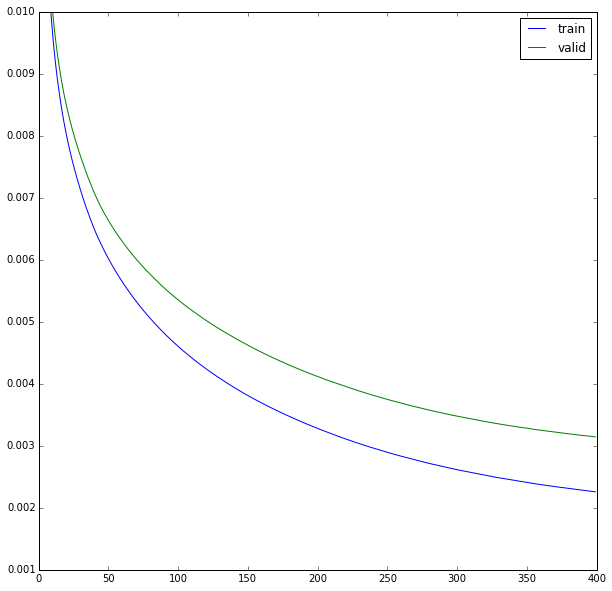

In [126]:
## the most important thing is to get as close as possible to data and model
## e.g., see the train and validation performance
## doesnt look like an overfit because valid is still flattening out
net1_train_errors = np.array([t["train_loss"] for t in net1.train_history_])
net1_valid_errors = np.array([t["valid_loss"] for t in net1.train_history_])
epochs = np.arange(0, train_errors.size)

plt.figure(figsize = (10, 10))
plt.plot(epochs, net1_train_errors, "b-", label = "train")
plt.plot(epochs, net1_valid_errors, "g-", label = "valid")
plt.legend(loc = "best")
plt.ylim((1e-3, 1e-2))

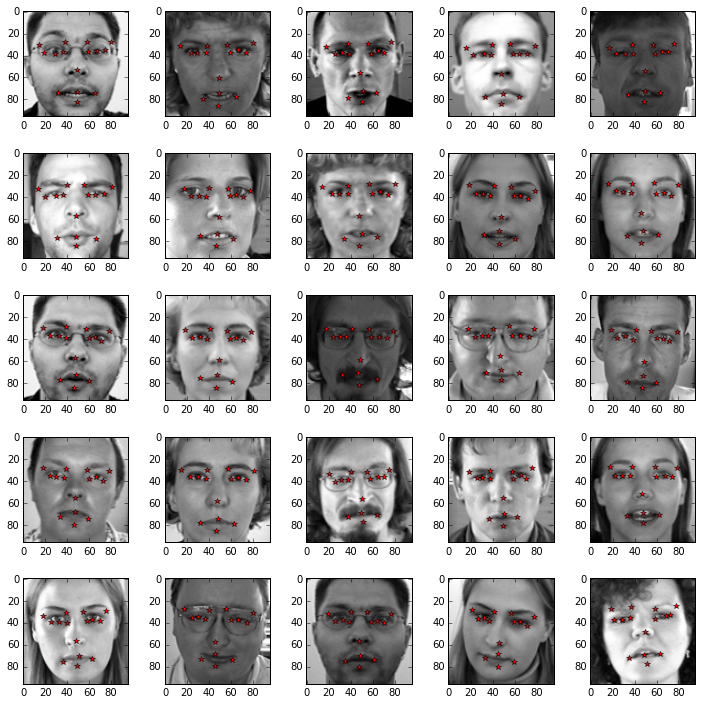

In [151]:
## how good or bad it applies to test data
def plot_face(img, ax):
    ax.imshow(img.reshape(96, 96), cmap = plt.cm.gray)
def plot_features(pts, ax):
    ax.autoscale(False)
    for pt in pts:
        x, y = pt
        ax.plot(x, y, "r*")
        
fig, axes = plt.subplots(5, 5, figsize = (10, 10))
fig.tight_layout()
axes = axes.ravel()
        
for i, ax in enumerate(axes):
    img = test_data.iloc[i]["Image"].astype(np.float32)
    features = net1.predict([img/255])[0] * 48. + 48.
    feature_pts = zip(features[0::2], features[1::2])
    plot_face(img, ax)
    plot_features(feature_pts, ax)

### Trying CNN

cnn takes (nchannel, width, height) images

In [152]:
## layer pattern is (conv, pool+)+
## number of filters are doubled each layer why????

net2 = NeuralNet(
    ## layers
    layers = [
        ("input", layers.InputLayer)
        , ("conv1", layers.Conv2DLayer)
        , ("pool1", layers.MaxPool2DLayer)
        , ("conv2", layers.Conv2DLayer)
        , ("pool2", layers.MaxPool2DLayer)
        , ("conv3", layers.Conv2DLayer)
        , ("pool3", layers.MaxPool2DLayer)
        , ("hidden4", layers.DenseLayer)
        , ("hidden5", layers.DenseLayer)
        , ("output", layers.DenseLayer)
    ]
    ## layer parameters
    , input_shape = (None, 1, 96, 96) # flexible batch size
    , conv1_num_filters = 32 
    , pool1_pool_size = (2, 2) # now 32 x 48 x 48
    , conv2_num_filters = 64
    , pool2_pool_size = (2, 2) # now 64 x 24 x 24
)